# Scraped Fixtures API Example

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/ScrapedFixtureAPI/ScrapedFixturesAPI.ipynb) 

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [46]:
signal_ocean_api_key = '' # replace with your subscription key

### Scraped Fixtures API  
The goal of Scraped Fixtures API is to collect and return the fixtures by the given filters.

For the ScrapedFixtureAPI, the required input arguments are: 
* Vessel Type
* The start date we want to extract the fixtures

In addition the user can request with following 3 optional arguments:
* Port id
* Vessel class id

## Setup

### Import libraries

In [55]:
%%capture
!pip install signal-ocean

import pandas as pd
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px


from signal_ocean import Connection
from signal_ocean.scraped_fixtures import ScrapedFixturesAPI

## Funtions

Plot functions
* Plot the top k senders with VLCC in the last 7 days with loading port in Ras Tanura
* Plot the daily number of fixtures for Ras Tanura/VLCC

In [56]:
def plot_senders(data, k, days):

    data_aggr = data \
              .groupby(['sender'])['fixture_id'] \
              .unique().reset_index()

    data_aggr['unique_fixture_ids'] = data_aggr \
                                            .apply(lambda x: len(x.fixture_id),axis=1)
    top_k = data_aggr \
          .sort_values('unique_fixture_ids') \
          .tail(k)
  
    fig = px.bar(top_k, 
               y='sender', 
               x='unique_fixture_ids' ,
               orientation='h',
               title="Top {} senders, last {} days, VLCC" \
                              .format(k, days)
               )
    
  
    fig.update_layout(
      xaxis_title="Number of fixtures",
      yaxis_title="Senders"
    )
    fig.show()

In [57]:
def plot_daily_fixtures(results):

    
    results['received_date'] = pd.to_datetime(results['received_date'])
    results['received_date'] = results['received_date'].dt.date
    fixtures_daily = results.groupby('received_date')['fixture_id'].unique().reset_index()
    fixtures_daily['unique_fixture_ids'] = fixtures_daily \
                                            .apply(lambda x: len(x.fixture_id),axis=1)
    fixtures_daily = fixtures_daily.sort_values('received_date')
    fig = px.bar(
      fixtures_daily, 
      title="Daily Fixtures",
      x='received_date', 
      y='unique_fixture_ids', 
    )
    fig.update_layout(
      yaxis_title="Number of fixtures",
      xaxis_title="Received Date"
    )
    fig.show()

## Results

### Example 

In the following example will extract the fixtures for the VLCC in the last 7 days with loading port in Ras Tanura

In [58]:
vessel_type_id = 1 
last_days = 7 
vessel_class_id = 84 
port_id = 3778 
date_from = date.today() - timedelta(days=last_days)
date_to = date.today()

connection = Connection(signal_ocean_api_key)
api = ScrapedFixturesAPI(connection)
scraped_fixtures = api.get_fixtures(
    received_date_from = date_from,
    received_date_to = date_to,
    vessel_type = vessel_type_id,
    port_id = port_id,
    vessel_class_id = vessel_class_id
)

results = pd.DataFrame([v.__dict__ for v in scraped_fixtures])
results.head(5)

,fixture_id,message_id,updated_date,received_date,reported_fixture_date,imo,vessel_class_id,laycan_from,laycan_to,load_geo_id,...,redelivery_to_name,redelivery_to_taxonomy,charterer_type,fixture_status,content,sender,is_private,is_invalidated,is_partial,is_deleted
0,85194776,22989770,2022-04-07 02:24:22+00:00,2022-04-07 02:23:57+00:00,None,9888601,84,2022-04-20 00:00:00+00:00,2022-04-22 00:00:00+00:00,3778,...,None,None,None,None,dahlkut 2021 270 ras tanura / china 20-22 apr ...,Alliance Tanker,True,False,False,False
1,85200542,22993013,2022-04-07 04:31:00+00:00,2022-04-07 04:29:17+00:00,None,9888601,84,2022-04-20 00:00:00+00:00,2022-04-22 00:00:00+00:00,3778,...,None,None,None,None,dhalkut 270 nhc 20-22 apr rstan cina ws 40.5 u...,Raffles Shipbrokers,True,False,False,False
2,85222912,23005998,2022-04-07 09:02:30+00:00,2022-04-07 09:01:46+00:00,None,9888601,84,2022-04-20 00:00:00+00:00,2022-04-22 00:00:00+00:00,3778,...,None,None,None,FullyFixed,dhalkut 270 20-22/4 rt/china w40.5 unipec -ffx...,Fearnleys,True,False,False,False
3,85236126,23009817,2022-04-07 10:44:21+00:00,2022-04-07 10:36:56+00:00,None,9455662,84,2022-04-26 00:00:00+00:00,2022-04-26 00:00:00+00:00,3778,...,None,None,None,None,dht opal 274 26/04 rtan/onsan w52.5 s-oil,SSY,True,False,False,False
4,85246733,23010296,2022-04-07 12:16:16+00:00,2022-04-07 10:36:56+00:00,None,9455662,84,2022-04-26 00:00:00+00:00,2022-04-26 00:00:00+00:00,3778,...,None,None,None,None,dht opal 274 26/04 rtan/onsan w52.5 s-oil,SSY,False,False,False,False


#### Plot top 10 senders

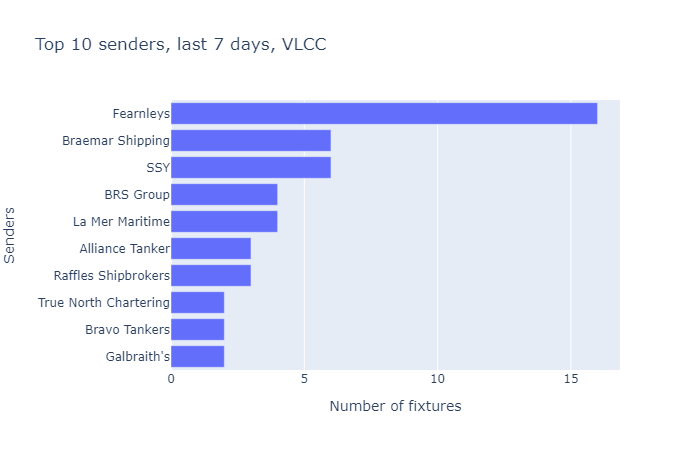

In [59]:
plot_senders(results, k=10, days=last_days)

#### Get the daily number of fixtures for Ras Tanura/VLCC

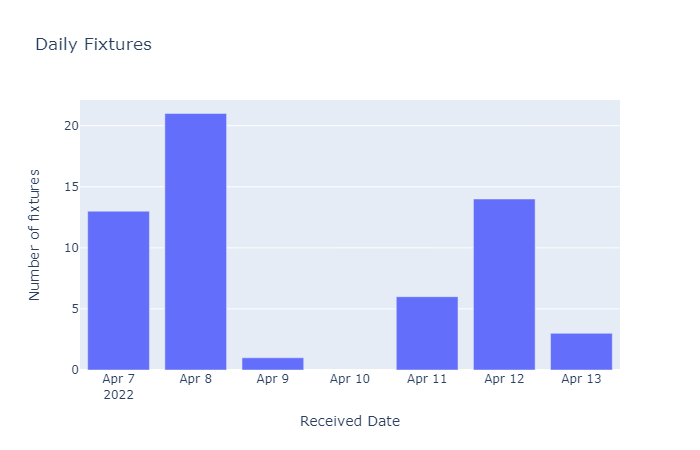

In [60]:
plot_daily_fixtures(results)

#### Export Results to CSV

In [53]:
output_path = '' # Change output_path with your path
filename = 'vlcc_one_week_scraped_fix.csv'
results.to_csv(output_path+filename,index=False)